# Delayed Flight Site

### GitHub Repo:
https://github.com/trentbellinger/PIC-16B-Project.git

## Objective
Our objective was to use predictive analytics to enhance travel planning. Using historical flight data, our platform gives travelers insight to potential delays on their upcoming flights, minimizing the inconvenience of delays. The ultimate goal is to transform how travelers approach flying, shifting from reactive to proactive planning.

## Overview
The Delayed Flight Site is a web-based application designed to predict flight departure delays within the United States. It aims to assist frequent flyers in efficiently organizing their flight schedules and travel plans by allowing them to anticipate and plan for potential delays. Our project will follow this path: data acquisition -> SQL database creation -> model creation -> web app creation -> complex visuals. We first acquire data about flights in the US, storing this data in a SQL database. We then create a predictive model that determines whether a given flight will be delayed. Then, we create an interactive web app that allows users to inputs their flight or itenerary details and outputs information about their flight and a predicted delay. This web app will have the following features: Itinerary to Save User-Inputted Flights, Flight Delay Predictions Based on User input, and Interactive Visualizations for Additional Insight. Then, we create interactive complex visualizations that will display on the applicationa and will change with user input. This procedure is displayed in the flow chart here:

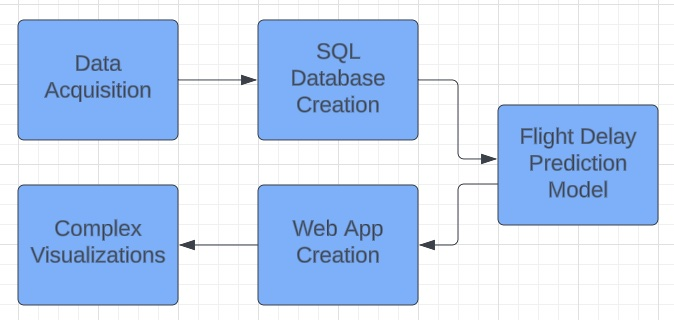

In [4]:
# @title Flowchart
from IPython.display import Image, display

# Correct path with no spaces in folder names
image_path0 = '/content/drive/MyDrive/PIC16B_Datasets/flowchart.jpeg'

# Display the image
display(Image(filename=image_path0))

## 1. Data Acquisition and SQL Database Creation

We started by importing flights data from the US Bureau of Transportation. This data was obtained through the following link:
<br>https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGK&QO_fu146_anzr=b0-gvzr<br>
The data that we got was organized by month, so we imported data from November of 2022 to November of 2023. The data contains all flights that have departure and arrival location in the United States. Each of the monthly datasets are loaded in below. We could not put these datasets into our GitHub because they were too large, so this process will only work on computers where the data is already uploaded. You can manually load in the data using the above link. We started with a separate `pandas` dataframe for each month, and concatenated it into a single dataframe containing all the data we collected. As we can see, the data has 7,818,349 rows and 30 columns, and was about 3GB when downloaded as a csv file. Each column contains different information about the flight, and a brief summary of each column is given in the FlightDelayModel.ibynp in the GitHub.

In [ ]:
import pandas as pd
import os

os.chdir('/content/drive/MyDrive/PIC16B_Datasets')

nov22 = pd.read_csv("nov22.csv")
dec22 = pd.read_csv("dec22.csv")
jan23 = pd.read_csv("jan23.csv")
feb23 = pd.read_csv("feb23.csv")
mar23 = pd.read_csv("mar23.csv")
apr23 = pd.read_csv("apr23.csv")
may23 = pd.read_csv("may23.csv")
jun23 = pd.read_csv("jun23.csv")
jul23 = pd.read_csv("jul23.csv")
aug23 = pd.read_csv("aug23.csv")
sep23 = pd.read_csv("sep23.csv")
oct23 = pd.read_csv("oct23.csv")
nov23 = pd.read_csv("nov23.csv")
all_data = pd.concat([nov22, dec22, jan23, feb23, mar23, apr23, may23, jun23, jul23, aug23, sep23, oct23, nov23],
                     ignore_index = True, axis = 0)
all_data.shape

<ipython-input-3-d6c0b08a5729>:8: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  jan23 = pd.read_csv("jan23.csv")
<ipython-input-3-d6c0b08a5729>:14: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  jul23 = pd.read_csv("jul23.csv")


(7818349, 50)

After getting data about each flight, we also wanted to get longitude and latitude data for each airport to be able to eaily plot our observations. This was done through an API called `airportsdata`. We will create a pandas dataframe using the airports data that contains the longitude and latitude of every airport in the United States. This process is outlined below.

In [ ]:
!pip install -U airportsdata
import airportsdata
airports = airportsdata.load('IATA')  # key is the ICAO identifier (the default)
airports_df = pd.DataFrame([(airport, dic["lat"], dic["lon"]) for airport, dic in airports.items()])
airports_df.rename(columns = {0:"AIRPORT_ID", 1:"LATITUDE", 2:"LONGITUDE"}, inplace = True)
airports_df.head()

AIRPORT_ID   LATITUDE   LONGITUDE
0        OCA  25.324317  -80.275729
1        CYT  60.080849 -142.495494
2        FWL  62.509183 -153.890626
3        CSE  38.851937 -106.932821
4        CUS  31.823711 -107.626967

Now that we have two large datasets, we will create a SQL database to store the data. The creation of a SQL database will allow us to easily look at subsets of the data without having to load in the whole dataframe. This will significantly speed up the data loading for the rest of our project. We will use this SQL database in every aspect of our project from now on. This SQL database is created below.

In [ ]:
import sqlite3

conn = sqlite3.connect("flights.db")

all_data.to_sql("flights", conn, if_exists = "replace", index = False)
airports_df.to_sql("airports", conn, if_exists = "replace", index = False)

conn.close()

We will now perform a couple small tests to ensure that the adtabase is working as intended. First, we will try to select the origin, destination, flight number, and departure delay for all United Airlines flights on Noverber 1, 2022 that were delayed over 15 minutes.

In [ ]:
with sqlite3.connect("flights.db") as conn:
    cmd = \
    f"""
    SELECT
        ORIGIN, DEST, OP_CARRIER_FL_NUM, DEP_DELAY
    FROM
        flights
    WHERE
        YEAR = "2022"
        AND
        MONTH = 11
        AND
        DAY_OF_MONTH = 1
        AND
        OP_UNIQUE_CARRIER = "9E"
        AND
        DEP_DEL15 = 1
    """
    df_test = pd.read_sql_query(cmd, conn)

print(df_test.shape)
df_test.head()

(31, 4)


ORIGIN DEST  OP_CARRIER_FL_NUM  DEP_DELAY
0    LGA  CVG               4635       22.0
1    CAE  ATL               4675       22.0
2    IND  JFK               4694       20.0
3    BNA  LGA               4737      105.0
4    LGA  MCI               4743      146.0

We will not preform a small test to make sure the table is functional in our database. We will output a dataframe of the airport id, latitude, and longitude of all airports lower than -100 longitude.

In [ ]:
with sqlite3.connect("flights.db") as conn:
    cmd = \
    """
    SELECT
        AIRPORT_ID, LATITUDE, LONGITUDE
    FROM
        airports
    WHERE
        LONGITUDE < -100
    """
    df_airports_test = pd.read_sql_query(cmd, conn)

print(df_airports_test.shape)
df_airports_test.head()

(1114, 3)


AIRPORT_ID   LATITUDE   LONGITUDE
0        CYT  60.080849 -142.495494
1        FWL  62.509183 -153.890626
2        CSE  38.851937 -106.932821
3        CUS  31.823711 -107.626967
4        ICY  59.969019 -141.661770

We can see that the database works as intended. This database will be very important for our project because it will allow us to quickly subset our dataset that contains about 8 million observations. The general structure of the database is displayed in the visualization below.

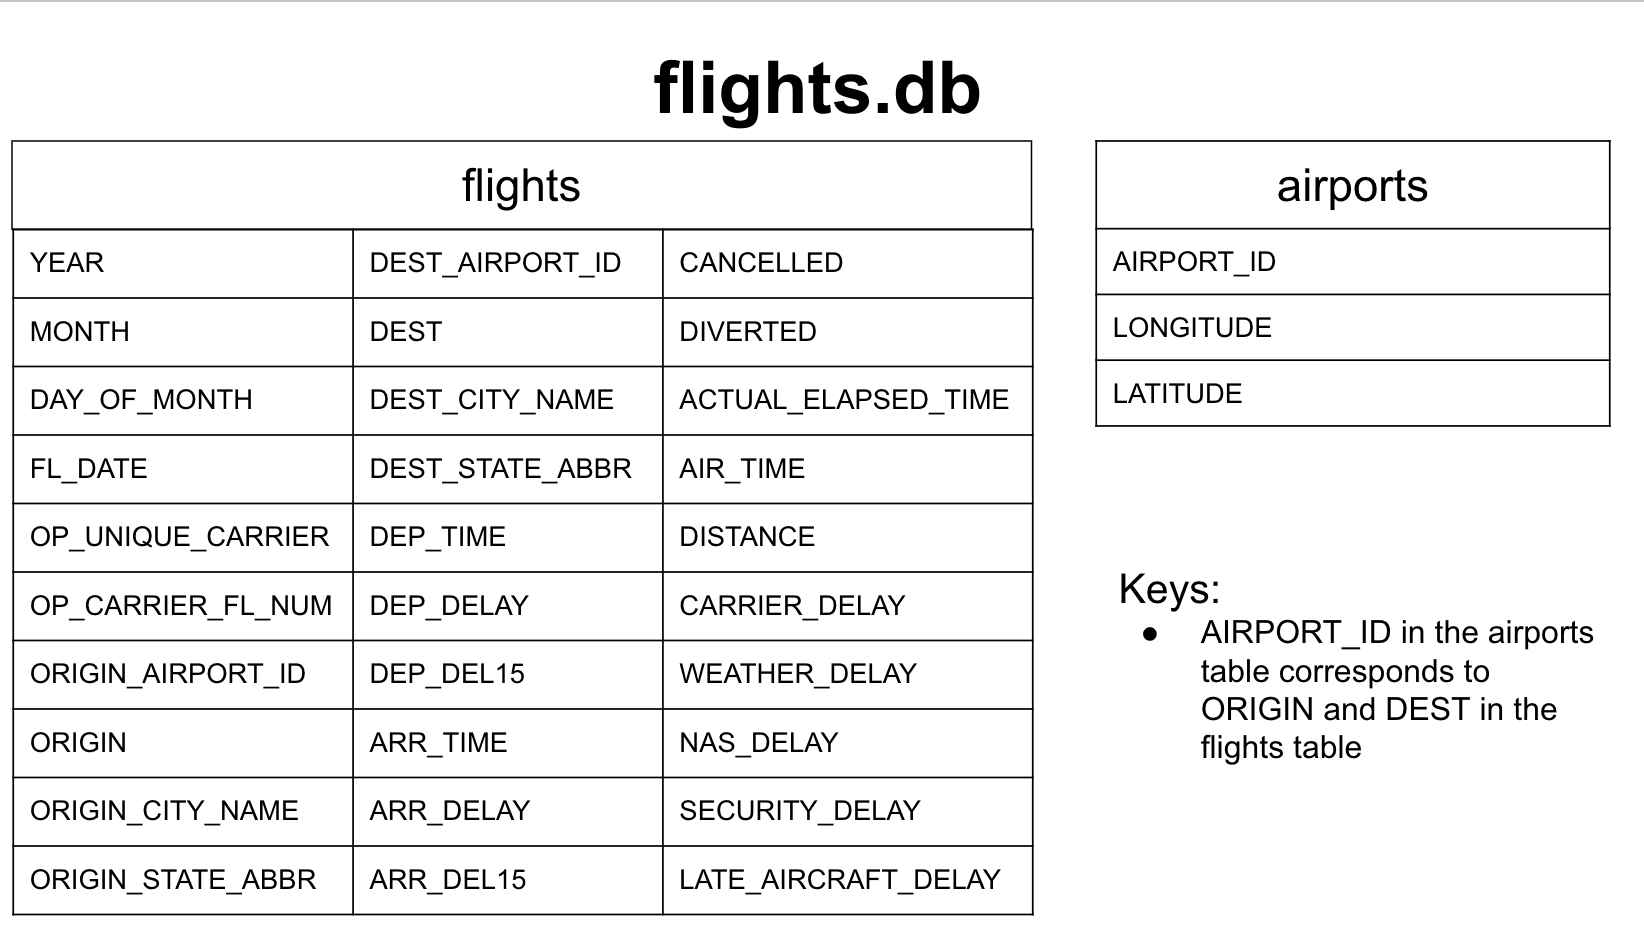

## 2. Data Preprocessing and Building a Model

Now that we have all the data that we need to proceed with our project, our goal for this section is to create a model that predicts whether a flight will be delayed by over 15 minutes. This is a binary classification problem. Thiw will correspond to the binary varuable DEP_DEL15 in the flights table of our SQL database. To predict this, we plan to use the flight departure date and time, arrival date and time, departure airport, arrival airport, carrier, and distance. This should give us enough insight because most delays are destination or airline specific.
These predictors correspond to the columns YEAR, MONTH, DAY_OF_MONTH, CARRIER, DEP_TIME, ARR_TIME, DISTANCE in the flights table and the columns LATITUDE and LONGITUDE in the airports table. We will create a function to output these variables from the SQL database. This function will select the desired predictors from the flights table while joining the airports table by airport ID. The code for the function is shown and it is tested below.

In [ ]:
import sqlite3
import pandas as pd
import os

os.chdir('/content/drive/MyDrive/PIC16B_Datasets')

def get_flight_model_data():
    '''
    Returns a pandas dataframe of all the necessary predictors to predict flight delay.
    (note: must have the flights.db database)
    Args:
        none
    Returns:
        a pandas dataframe with all necessary predictors
    '''
    with sqlite3.connect("flights.db") as conn:
        cmd = \
        """
        SELECT
            flights.YEAR, flights.MONTH, flights.DAY_OF_MONTH, flights.DEP_TIME, flights.ARR_TIME,
            flights.OP_UNIQUE_CARRIER, flights.ORIGIN, flights.DEST, flights.DISTANCE, flights.DEP_DEL15,
            airports.LATITUDE "ORIGIN_LATITUDE", airports.LONGITUDE "ORIGIN_LONGITUDE"
        FROM
            flights
        INNER JOIN
            airports ON flights.ORIGIN = airports.AIRPORT_ID
        """
        df = pd.read_sql_query(cmd, conn)
    with sqlite3.connect("flights.db") as conn:
        cmd = \
        """
        SELECT
            flights.DEST, airports.LATITUDE "DEST_LATITUDE", airports.LONGITUDE "DEST_LONGITUDE"
        FROM
            flights
        INNER JOIN
            airports ON flights.DEST = airports.AIRPORT_ID
        """
        df_dest = pd.read_sql_query(cmd, conn)
    df["DEST_LATITUDE"] = df_dest["DEST_LATITUDE"]
    df["DEST_LONGITUDE"] = df_dest["DEST_LONGITUDE"]
    return df

df = get_flight_model_data()
print(df.shape)
df.head()

(7818349, 14)


YEAR  MONTH  DAY_OF_MONTH  DEP_TIME  ARR_TIME OP_UNIQUE_CARRIER ORIGIN  \
0  2022     11             1    1355.0    1747.0                9E    XNA   
1  2022     11             1    1412.0    1609.0                9E    LGA   
2  2022     11             1    1345.0    1550.0                9E    LGA   
3  2022     11             1    1550.0    1648.0                9E    LSE   
4  2022     11             1    1418.0    1506.0                9E    MSP   

  DEST  DISTANCE  DEP_DEL15  ORIGIN_LATITUDE  ORIGIN_LONGITUDE  DEST_LATITUDE  \
0  LGA    1147.0        0.0        36.281579        -94.307766      40.777250   
1  CVG     585.0        1.0        40.777250        -73.872611      39.048837   
2  XNA    1147.0        0.0        40.777250        -73.872611      36.281579   
3  MSP     119.0        0.0        43.879266        -91.256634      44.881972   
4  LSE     119.0        0.0        44.881972        -93.221778      43.879266   

   DEST_LONGITUDE  
0      -73.872611  
1      -84.667821  
2      -94.307766  
3      -93.221778  
4      -91.256634

Now that we have our data, we must proceed to making our data ready to be inputted into our model. There is only one categorical predictor, OP_UNIQUE_CARRIER. We need to see if there are any similarities between carriers to encode the predictor. We will first look at the proportion of delayed flights with the same carrier to see if there is any grouping we can make. This could potentially give some feedback in the final model, but after the model was tested this was the most efficient way to encode these variables. We will also look at the average distance of flights with the same carrier to see if there is any grouping we can make. As shown in the scatterplot below, there are four main groups, which we will use to encode the carriers. There is one group in the bottom left, one group in the top right, one group in the bottom middle and one group in the top middle. We will encode the flight carriers PT, YX, 9E, QX, OH, OO, C5, G7, and MQ as 0, HA, ZW, YV, and WN as 1, DL, AA, G4, UA, and AS as 2, and B6, F9, and NK as 3.

2    3244790
0    2013241
1    1786664
3     773654
Name: OP_UNIQUE_CARRIER, dtype: int64

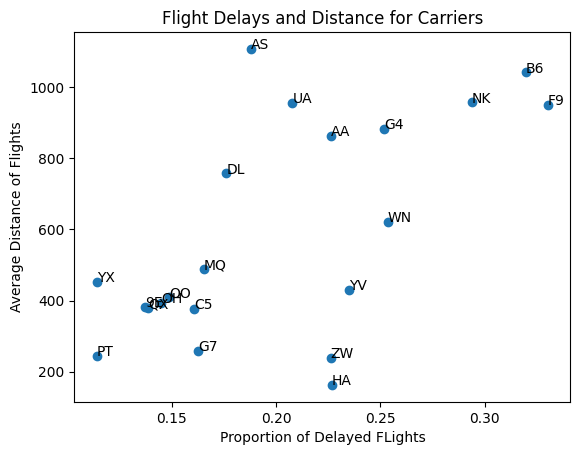

In [ ]:
import matplotlib.pyplot as plt

# get proportion of delays for each carrier
carrier_groups = df[["OP_UNIQUE_CARRIER", "DEP_DEL15"]].groupby("OP_UNIQUE_CARRIER")
carrier_delays = carrier_groups.mean()

# get median distance of flight for each carrier
carrier_groups = df[["OP_UNIQUE_CARRIER", "DISTANCE"]].groupby("OP_UNIQUE_CARRIER")
carrier_distances = carrier_groups.median()

# create a plot of proportion of delays vs average diatance
fig, ax = plt.subplots()
ax.scatter(x = carrier_delays, y = carrier_distances)
ax.set_title("Flight Delays and Distance for Carriers")
ax.set_xlabel("Proportion of Delayed FLights")
ax.set_ylabel("Average Distance of Flights")

for i, txt in enumerate(carrier_delays.index):
    ax.annotate(txt, (carrier_delays["DEP_DEL15"][i], carrier_distances["DISTANCE"][i]))

# encode the OP_UNIQUE_CARRIER column
df["OP_UNIQUE_CARRIER"].replace({"PT":0, "YX":0, "9E":0, "QX":0, "OH":0, "OO":0, "C5":0, "G7":0, "MQ":0, "HA":1, "ZW":1, "YV":1, "WN":1, "DL":2, "AA":2, "G4":2, "UA":2, "AS":2, "B6":3, "F9":3, "NK":3}, inplace = True)
df["OP_UNIQUE_CARRIER"].value_counts()

Now that we have all of our variables prepped to use in our model, we must figure out how to deal with NA values in our data.
There were a small number in proportion to the size of the data, as shown below. We can see that about 0.35% of the data is NA values. This is an extremely small amount, so we will deal with the NAs by simply removing any rows that contain NA values, which is also done below.

In [ ]:
print("Proportion of NAs: ", (df.isna().sum().sum()) / df.size)
print("Shape before dropping NAs: ", df.shape)
df = df.dropna()
print("Shape after dropping NAs: ", df.shape)

Proportion of NAs:  0.0034782736282119335
Shape before dropping NAs:  (7818349, 14)
Shape after dropping NAs:  (7687386, 14)


We will now check the rate at which our model should perform. This will be done by looking at the proportion of flights which are delayed, done below. As we can see, the data is extremely imbalanced. There are way more non-delayed flights than theer are delayed flights. The base rate is about 0.8, which is going to be very high for the model that we plan to create because of outside variability. Seeing that we have over 7 million observations, we can certainly even out this category in the data to make the model more accurate. We will remove some of the data of the non-delayed flights to make the number of flights in each category equal. This is done below.

In [ ]:
print("Proportion of delayed flights: ", df["DEP_DEL15"].mean())
print("Proportion of non-delayed flights: ", 1 - df["DEP_DEL15"].mean())

# make the number of delayed and not delayed flights equal
g = df.groupby('DEP_DEL15')
df = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
print("New data shape: ", df.shape)

print("New proportion of delayed flights: ", df["DEP_DEL15"].mean())
print("New proportion of non-delayed flights: ", 1 - df["DEP_DEL15"].mean())

Proportion of delayed flights:  0.20882612112882065
Proportion of non-delayed flights:  0.7911738788711793
New data shape:  (3210654, 14)
New proportion of delayed flights:  0.5
New proportion of non-delayed flights:  0.5


We will now create a training and testing dataset for our model, done below. We will set aside 20% for testing and keep 80% for training.

In [ ]:
from sklearn.model_selection import train_test_split

model_X = df[['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DEP_TIME', 'ARR_TIME', 'OP_UNIQUE_CARRIER', 'DISTANCE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE']]
model_y = df[['DEP_DEL15']]
X_train, X_test, y_train, y_test = train_test_split(model_X, model_y, test_size = 0.2, random_state = 50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2568523, 11) (642131, 11) (2568523, 1) (642131, 1)


We can now move on to model fitting. We started with training many deep neural network models, which took very long to train and were ultimately not as successful as we hoped. Our best model ended up being a random forest classifier, as shown below. we tested different values for n_estimators, max_depth, min_samples_split, and min_samples leaf, but the best accuracy with the default values used by RandomForestClassifier(). As we can see, the model predicts whether a flight will be delayed with 83% accuracy. This is very good, expecially considering the amount of variabiliy that goes into flight delays.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=0)
rf.fit(X_train, np.array(y_train).flatten())
rf.score(X_test, np.array(y_test).flatten())

The above code was not able to be run due to the size of the data, but the model has 83% test accuracy.

## 3. Making a Flask Web App

Our Flask web app is designed to grant a user intuitive access to the features that our project provides. Primarily, checking the delay status of individual flights as well as creating itineraries that can be visualized using the Plotly Dash apps described in the following sections. Additionally, we added the option for a user to create an account in order to save flights and itineraries to be viewed at a later time.


### Site Database Creation

The first step taken in the web app was to create a database that stored the information for each user. This database contained three tables: user, itineraryCounter, and itineraries. The user table stored the usernames as well as the hashed passwords of each user, a table called when logging in or creating a new account. The itinerary counter table served as a way to help index our final table, itineraries. This itinerary page contained several columns: itin_id, author_id, origin, destination, airline, depDate, and arrTime. Each row in this table represents a single flight, with the itin_id and author_id letting us know which itinerary that flight belongs to. The code for The creation of our database is contained below within our get_db() function, which simultaneously opens a connection with the database, as well as creating the tables if they have not already been created.

In [ ]:
'''
Opens up connection with the database, creating the necessary tables if they have not already been created.
'''
def get_db():
    if 'db' not in g:
        #connecting to database
        g.db = sqlite3.connect("webProj.sqlite")
        #creating cursor so we can interact with database
        cursor = g.db.cursor()
        #execute creation of tables using (CREATE TABLE IF NOT EXISTS)
        #creatin table for user login information
        cursor.execute("CREATE TABLE IF NOT EXISTS user ( id INTEGER PRIMARY KEY AUTOINCREMENT, username TEXT UNIQUE NOT NULL, password TEXT NOT NULL)")
        #creating table for itinerary identification
        cursor.execute("CREATE TABLE IF NOT EXISTS itineraryCounter ( id INTEGER PRIMARY KEY AUTOINCREMENT, counter TEXT)")
        #creating table holding information to be stored in itineraries (ex. flight info), to be tied back to each itinerary in previous table via itin_id value
        cursor.execute("CREATE TABLE IF NOT EXISTS itineraries ( id INTEGER PRIMARY KEY AUTOINCREMENT, itin_id INTEGER NOT NULL, author_id TEXT, origin TEXT, destination TEXT, airline TEXT, depTime TEXT, arrTime TEXT)")
        #allowing us to access columns by their name
        g.db.row_factory = sqlite3.Row
        #commiting cursor changes
        g.db.commit()
    return g.db

### Registration and Login

Now that we have our database set up, we can begin to register users and save itineraries. In order to register, we must take in the input from the user, ensuring that their requested username is not already in use by another user, and hash their password for security purposes. Additionally, after their successful registration, we reroute them to the login page where they can test that their new login information is working correctly. The functions are pictured below.

In [ ]:
'''
Page used for registering new users into the database. Takes in user input for
username and password, ensuring username is not already taken, before rerouting to
login page.
'''
@auth_bp.route('/register', methods=('GET', 'POST'))
def register():
    if request.method == 'POST':
        #getting user input for their desired username and password
        username = request.form.get('username')
        password = request.form.get('password')
        #opening connection with the database
        db = get_db()
        error = None

        #checks to make sure username and password are filled out
        if not username:
            error = 'Username is required.'
        elif not password:
            error = 'Password is required.'


        if error is None:
            #inserts user information into database
            try:
                db.execute("INSERT INTO user (username, password) VALUES (?,?)", (username, generate_password_hash(password)),
                )
                db.commit()
            #checks if username already exists
            except db.IntegrityError:
                error = f"Username {username} is already registered."
            else:
                #sends user to login page where they can login with their newly created account
                return redirect(url_for("auth.login"))
        #error shown to user if there is one
        flash(error)
    return render_template('auth/register.html')

We can see that we first gather user input by assigning our username and password variables as the input from request forms displayed on the resgister page. We then open up a connection to the database using the get_db() function we creating previously, which will allow us to check that the username is not already in use. To accomplish this, we use a try statement in which we insert the username and the hashed password into the user table, excepting an IntegrityError, which would imply that the username is already in use. It that is the case, we send a message to the user that their chosen username is already in use, prompting them to choose a new one. If not, the username and password combination will be placed in the user table, and the user will be redirected to the login page, as shown by the redirect near the end of the code block. Below is an example of the error message shown when trying to register a username that is already taken.  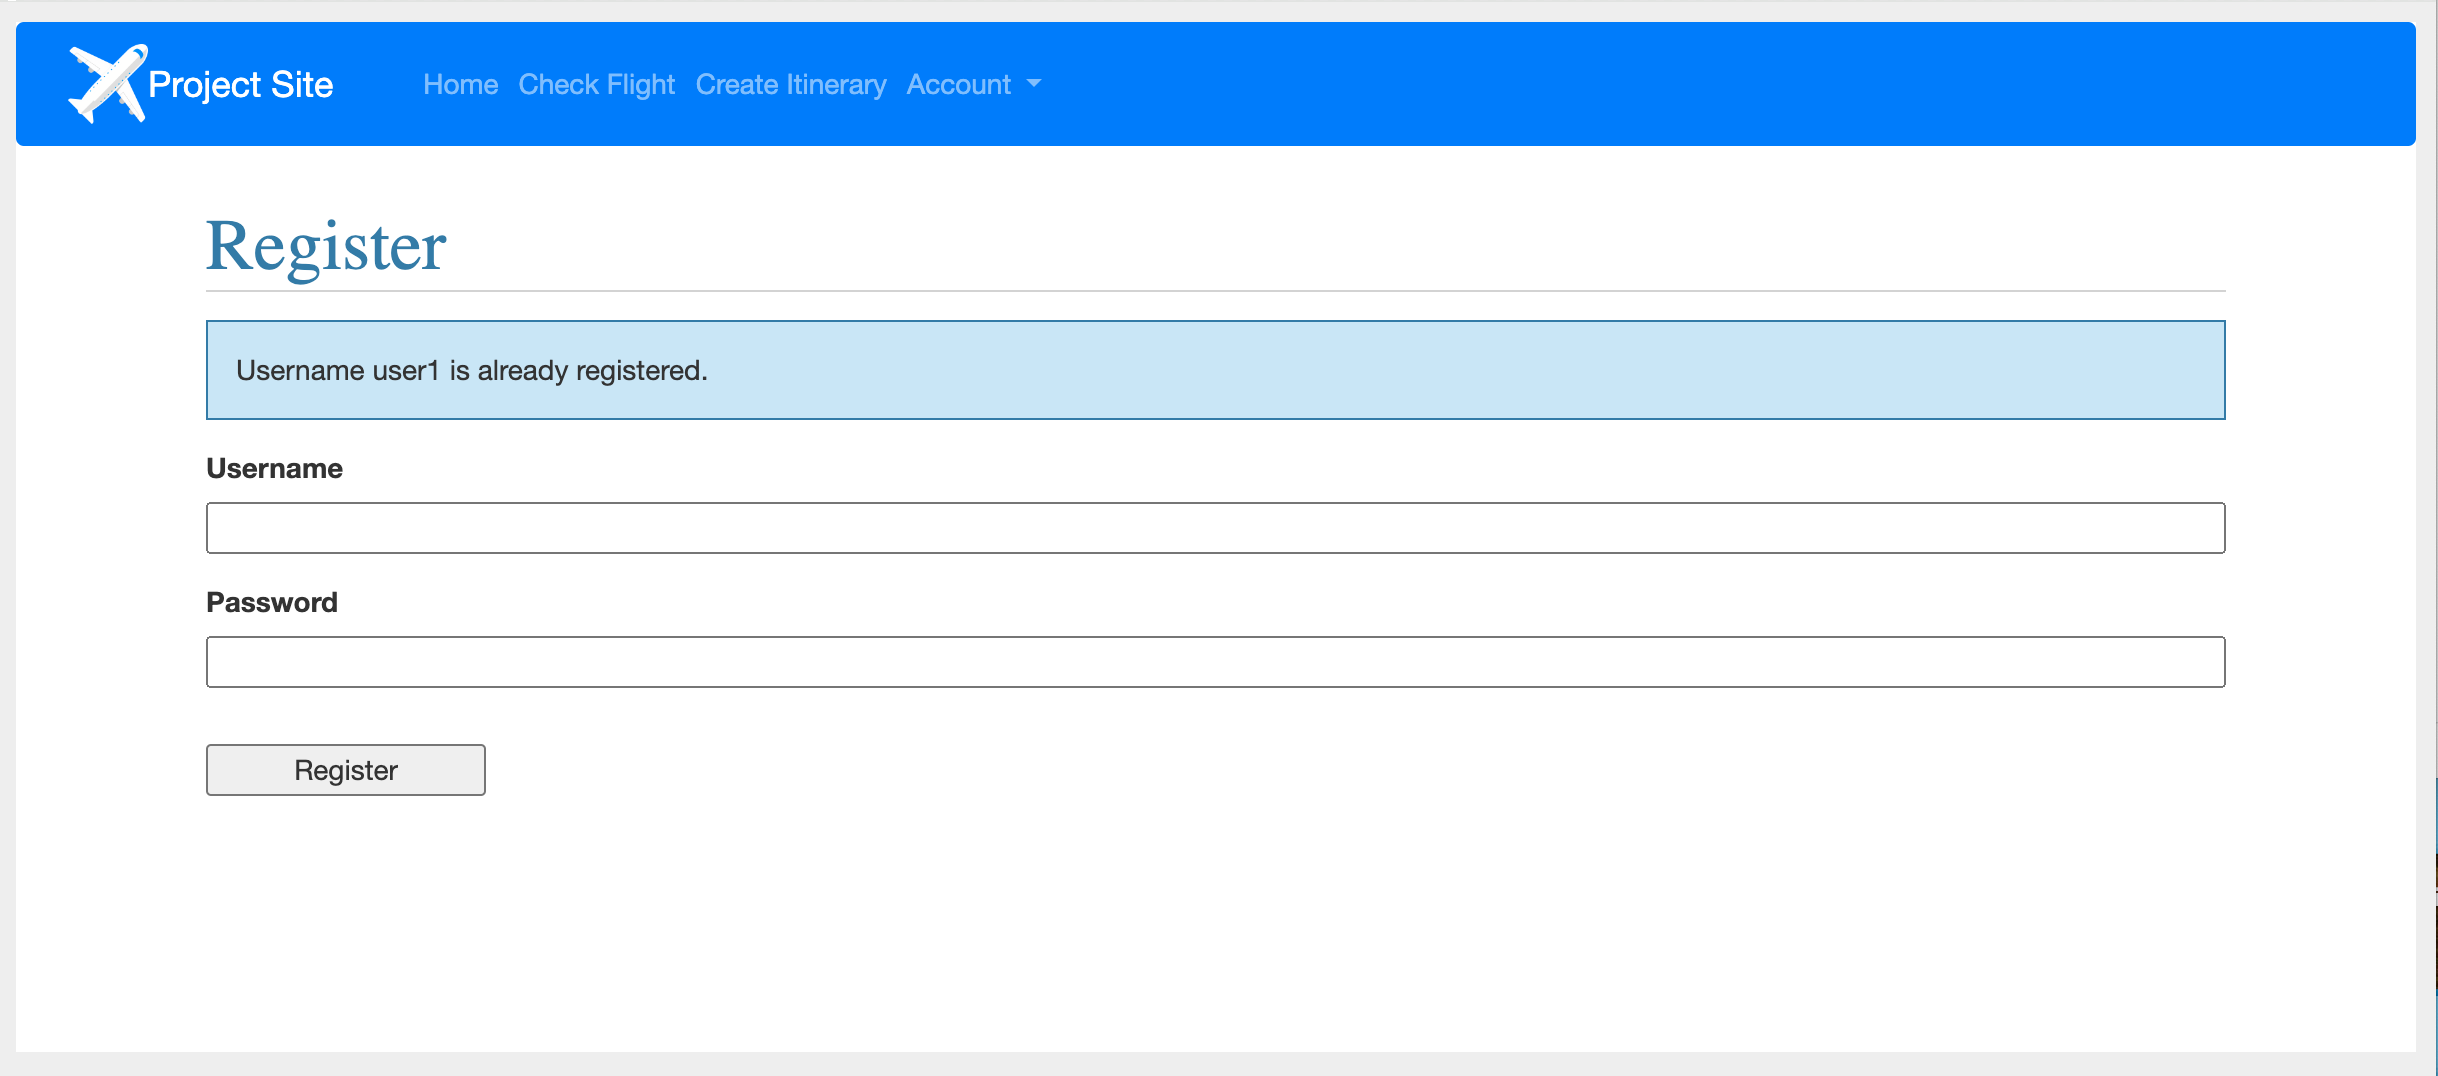

In [ ]:
'''
Page where users are able to log back in.
'''
@auth_bp.route('/login', methods = ('GET', 'POST'))
def login():
    if request.method == 'POST':
        #user enters their username and password
        username = request.form.get('username')
        password = request.form.get('password')
        #opens connection with database
        db = get_db()
        error = None
        #checks for username in database
        user = db.execute('SELECT * FROM user WHERE username = ?', (username,)).fetchone()
        #gives error if username not found
        if user is None:
            error = 'Incorrect username.'
        #checks username password against inputted password
        elif not check_password_hash(user['password'],password):
            error = 'Incorrect password.'
        #resets session and sets user id to user who just logged in
        if error is None:
            session.clear()
            session['user_id'] = user['id']
            #sends us back to main page, now as a logged in user
            return redirect(url_for('index'))
        #flashes error if one exists
        flash(error)
    return render_template('auth/login.html')

Similar to the register page, we gather user information using request.form.get() commands, and then open a connection with the database using get_db(). We then check to ensure that the inputted username is contained within the user table, using the cursor db that is returned by the get_db() function. If nothing is returned, that means the username is not contained within the table, which means that username is not associated with any existing user. Therefore, we send an incorrect user message, and prompt them to enter a different username. If the username is contained within the table, we can then move on to checking that the inputted password is correct. However, as we hashed the password for security reasons on the register page, we cannot simply check that user['password']==password, as it would almost always return false. Instead, we call the function check_password_hash(), and pass in the hashed user password contained within the database, as well as the inputted password. This will now check that the hashed versions of the passwords match up, which if true means that the user has successfully inputted their login information and should now be fully logged in. In order to accomplish this, we set the session['user_id'] to be the inputted username. Note that we clear the session ahead of time just in case. The session stores variables that will be able to be used across all pages contained within the app, and as the information of the logged in user will be used across most pages, it makes sense to store it as a session variable.

### Handling User Input

Now that we have finished the registration and login functionality of our site, we can begin to create the ability for the user to input flights and itineraries. Let us first look at taking in the input for an individual flight, which is displayed on our 'flights' page. We plan on taking in information regarding the origin, destination, airline, departure time, and arrival time of each flight. Therefore we will need to initialize five variables for this function, assigning them the values inputted by the user by again using request.form.get(). Now that we have obtained the input from the user, we can perform a bit of data processing by formatting the date into a more visually appealing format, accomplished by use of the strptime and strftime functions. After checking that each form has been filled out, we can begin to utilize this data. We first create a dictionary containing all of the flight data called flightDict, and append it to an empty list flightList. While it appears that creating a list with a single dictionary within it seems somewhat redundant, this helps to fit the format of when we have multiple flights from an itinerary. We then use the inputs we have received and use them to run the model we created, described in section two of the post, which will tell us whether or not we expect the flight to be delayed. Finally, we utilize a redirect to the 'flightDisp' page which will display all the user inputs, as well as the results of the model for our user to see. It is critical that we also pass the flight information as well as the result of the model that we just ran to the next page as well. You may be confused as to way we are passing each variable individually as opposed to the list we created, and it is due simply to the fact that when passing values this way, it is much simpler to obtain them on the next page when they are passed one by one.

In [ ]:
'''
Page where user enters a single flight to check the estimate of it being delayed. Page is reached via the link in the navbar and will redirect to /flightDisp page where flight information is to be displayed.
'''
@server.route('/flights', methods = ['GET', 'POST'])
def flights():
    if request.method == 'POST':

        # Obtaining flight input from user
        origin = request.form.get('origin')
        destination = request.form.get('destination')
        airline = request.form.get('airline')
        date = request.form.get('date')
        arrivalTime = request.form.get('arrivalTime')

        # Altering format of date to make it more readable
        date = dt.strptime(date, '%Y-%m-%dT%H:%M')
        date = date.strftime('%d/%m/%Y %H:%M')

        # Altering formate of arrivalTime to make it more readable
        arrivalTime = dt.strptime(arrivalTime, '%Y-%m-%dT%H:%M')
        arrivalTime = arrivalTime.strftime('%d/%m/%Y %H:%M')

        # Initializing error to be none
        error = None

        # Checking all fields have been filled out, yielding an error if not
        if not origin:
            error = 'Please enter origin.'
        elif not destination:
            error = 'Please enter destination.'
        elif not airline:
            error = 'Please select an airline.'
        elif not date:
            error = 'Please input a departure date and time.'
        elif not arrivalTime:
            error = 'Please enter your estimated arrival time.'
        if error is None:
            # Creating flightList that will be passed to our layout function
            flightList = []

            # Initializing flightDict that contains all of the entered flight information
            flightDict = {'origin': origin, 'destination': destination, 'airline': airline, 'depDate':date, 'arrDate':arrivalTime}

            # Placing flight information into flightList
            flightList.append(flightDict)

            # Calling layoutDash to pass the flight information to Dash app, passed in name of app and flightList
            #layoutDash(dash1, flightList)

            # get airline abbreviation
            airline_abr = airlineDict[airline]

            # get day, month, year, and time as integers
            dep_date_split = date.replace('/', ' ').replace(':', ' ').split()
            day_of_month = int(dep_date_split[0])
            month = int(dep_date_split[1])
            year = int(dep_date_split[2])
            dep_time = int(dep_date_split[3] + dep_date_split[4])

            # get arrival time
            arr_date_split = arrivalTime.replace('/', ' ').replace(':', ' ').split()
            arr_time = int(arr_date_split[3] + arr_date_split[4])

            # get origin longitude and latitude
            origin_lon = airport_coords_df.loc[airport_coords_df["ORIGIN"] == origin, "lon"].tolist()[0]
            origin_lat = airport_coords_df.loc[airport_coords_df["ORIGIN"] == origin, "lat"].tolist()[0]

            # get destination longitude and latitude
            dest_lon = airport_coords_df.loc[airport_coords_df["ORIGIN"] == destination, "lon"].tolist()[0]
            dest_lat = airport_coords_df.loc[airport_coords_df["ORIGIN"] == destination, "lat"].tolist()[0]

            distance = distances.loc[(distances["ORIGIN"] == origin) & (distances["DEST"] == destination), "AVG_DISTANCE"].tolist()[0]

            if airline in ['PT', 'YX', '9E', 'QX', 'OH', 'OO', 'C5', 'G7', 'MQ']:
                carrier = 0
            elif airline in ['HA', 'ZW', 'YV', 'WN']:
                carrier = 1
            elif airline in ['DL', 'AA', 'G4', 'UA', 'AS']:
                carrier = 2
            else:
                carrier = 3

            X_new = pd.DataFrame({'YEAR':year, 'MONTH':month, 'DAY_OF_MONTH':day_of_month,
                                  'DEP_TIME':dep_time, 'ARR_TIME':arr_time,
                                  'OP_UNIQUE_CARRIER':carrier, 'DISTANCE':distance,
                                  'ORIGIN_LATITUDE':origin_lat, 'ORIGIN_LONGITUDE':origin_lon,
                                  'DEST_LATITUDE':dest_lat, 'DEST_LONGITUDE':dest_lon}, index = [0])

            pred = rf_model.predict(X_new).tolist()[0]

            if pred == 0:
                delay = "our model predicts no delays for your flight."
            elif pred == 1:
                delay = "our model predicts that your flight will be delayed at least fifteen minutes."
            else:
                delay = "our model returned inconclusive results."

            # Send user to Dash app for visualization
            #return redirect('/dashFlight/')
            return redirect(url_for("flightDisp", origin=origin, destination=destination, airline=airline, date=date, arrivalTime=arrivalTime, delay=delay, pred = pred))

        # Flash error if one was present
        flash(error)

    #Rendering template, passing in airlineDict and flightInputDict to provide options in the searchable dropdown menus
    return render_template('blog/flights.html', airlineDict = airlineDict, flightInputDict = flightInputDict)

Note that our itinerary flights page is very similar to the above page, with a couple key exceptions. As our user is able to select how many flights they wish to place into their itinerary, we must run a for loop in order to ensure we take in all of their inputs. Additionally, we do not run the model as there are multiple flights in the itinerary, and it makes it much simpler and more efficient to do it in this manner.

In [ ]:
'''
Page where user is able to input the information for the number of flights they specified on the /itinNum page. Page will forward to /itinDisp page where the complete itinerary is to be displayed.
'''
@server.route('/itinFlights', methods = ('GET', 'POST'))
def itinFlights():
    # Get the number of flights passed from previous page
    numFlight = int(request.args.get('numFlight'))

    if request.method=='POST':
        # Instructions if user selects the 'See itinerary' button
        if request.form.get('action') == "See itinerary":
            # Initializing flightList that will contain the data for all of our flights
            flightList=[]

            # Run through loop for number of flights requested by user
            for i in range(0,numFlight):

                # Taking in user inputs for each flight
                origin = request.form.get(f'origin{i}')
                destination = request.form.get(f'destination{i}')
                airline = request.form.get(f'airline{i}')
                date = request.form.get(f'date{i}')
                arrivalTime = request.form.get(f'arrivalTime{i}')

                # Creating a dictionary for each flight, containing user's information
                flightDict = {'origin': origin, 'destination': destination, 'airline': airline, 'depDate':date, 'arrTime':arrivalTime}

                # Adding information from each flight to flightList
                flightList.append(flightDict)


            # Converting first depDate to a datetime object that we will be able to extract the hour value
            sesDate = dt.strptime(flightList[0]['depDate'], '%Y-%m-%dT%H:%M')

            # Saving variables to session so that the Dash app will be able to access them
            session['dateDash'] = sesDate.hour
            session['dashboard_id'] = flightList
            session['numFlight'] = numFlight

            # Sending user to Dash app for visualization
            return redirect(url_for('/dashFlight/', flightList = flightList))

        # Instructions if user clicks 'Save itinerary' button
        elif request.form.get('action') == "Save itinerary":

            # Initializing flightList that will contain the data for all of our flights
            flightList=[]

            # Run through loop for number of flights requested by user
            for i in range(0,numFlight):

                # Taking in user inputs for each flight
                origin = request.form.get(f'origin{i}')
                destination = request.form.get(f'destination{i}')
                airline = request.form.get(f'airline{i}')
                date = request.form.get(f'date{i}')
                arrivalTime = request.form.get(f'arrivalTime{i}')

                # Creating a dictionary for each flight, containing user's information
                flightDict = {'origin': origin, 'destination': destination, 'airline': airline, 'depDate':date, 'arrTime':arrivalTime}

                # Adding information from each flight to flightList
                flightList.append(flightDict)


            # Converting sesDate to a datetime object
            sesDate = dt.strptime(flightList[0]['depDate'], '%Y-%m-%dT%H:%M')

            # Saving certain variables to session so they can be used by next page
            session['dateDash'] = sesDate.hour
            session['dashboard_id'] = flightList
            session['numFlight'] = numFlight

            # Redirecting to save page
            return redirect(url_for('saveItin'))

    # Rendering template, passing in numFlight for iterative purposes, as well as two dictionaries that the searchable dropdowns will access for their options
    return render_template('blog/itinFlights.html', numFlight = numFlight, airlineDict=airlineDict, flightInputDict = flightInputDict)


### Saving Itineraries

Saving a flight or itinerary is relatively straightforward. The trickiest part of this process is ensuring that each flight in an itinerary is given the same itin_id so that they can be accessed all together when we wish to display them. The first thing we do is open a connection to the database as we will need to place new information into our database in order to save it. In order to increment our itin_id by one each time, we check the maximum itin_id from itineraries and then increment it by one to ensure we are not accidentally placing our new itinerary into an already existing itinerary. We then loop through each flight within our flightList, that we access using the session variable 'dashboard_id', and reformat our departure and arrival dates and times into a readable format. Note that we know how many flights are contained within the list by simply checking the length of the list, using that as the range of our for loop. Finally, we run another for loop within the same range, inserting a new row for each flight within our list, passing in the itin_id we found earlier as our itin_id, session['user_id'] as the author_id, and then the corressponding value from each flight to its respective column in the database. To finish it all off, we commit the changes to the database using db.commit() and then close our connection to the databse before redirecting to our 'itinDisp' page where the user will see their saved itineraries.

In [ ]:
'''
Saves a created itinerary and then reroutes to /allItins page. Only possible to be called if user is logged in.
Still need to write code and finish HTML file.
NOTE: May or may not be implemented
'''
@server.route('/saveItin')
@login_required
def saveItin():
    # Opening database connection
    db = get_db()
    # Using dummy variable to help assign itinerary ids
    dumVar = 'textCount'
    # Adding dummy variable to itineraryCounter table so we can figure out how many itineraries we have
    db.execute(
        'INSERT INTO itineraryCounter (counter) VALUES (?)',
        (dumVar,))
    # Commiting insertion into itineraryCounter
    db.commit()
    # Finding max itin_id from table and incrementing our variable by one for new itinerary
    itin_id = db.execute('SELECT MAX(itin_id) FROM itineraries').fetchone()[0]
    if itin_id is None:
        itin_id = 1
    else:
        itin_id += 1

    # Changing format of time for disply
    for i in range(0, len(session['dashboard_id'])):
        session['dashboard_id'][i]['depDate'] = dt.strptime(session['dashboard_id'][i]['depDate'], '%Y-%m-%dT%H:%M')
        session['dashboard_id'][i]['depDate'] = session['dashboard_id'][i]['depDate'].strftime("%d/%m/%Y %H:%M")
        session['dashboard_id'][i]['arrTime'] = dt.strptime(session['dashboard_id'][i]['arrTime'], '%Y-%m-%dT%H:%M')
        session['dashboard_id'][i]['arrTime'] = session['dashboard_id'][i]['arrTime'].strftime("%d/%m/%Y %H:%M")

    # Placing information into database for each flight in itinerary, all with same itin_id
    for i in range (0, len(session['dashboard_id'])):
        db.execute(
            'INSERT INTO itineraries (itin_id, author_id, origin, destination, airline, depTime, arrTime) VALUES (?,?,?,?,?,?,?)',
            (itin_id, session['user_id'], session['dashboard_id'][i]['origin'], session['dashboard_id'][i]['destination'], session['dashboard_id'][i]['airline'], session['dashboard_id'][i]['depDate'], session['dashboard_id'][i]['arrTime']))
    # Commit and close the database
    db.commit()
    db.close()
    # Sending user to itinerary page where they can see their newly saved itinerary
    return redirect(url_for('itinsDisp'))

### Displaying Saved Information

Now that we have allowed the user to save their itineraries, we need a way for them to be able to see and access these itineraries. This is accomplished on our 'dispItins' page. In order to access a user's itineraries, we need to access the database, hence we will again use the get_db() function to open up a connection with the database. We now need to create a list of all the flights saved under a certain user in our itineraries table. To accomplish this, we use our cursor from get_db() to execute a command that selects all of the columns from each flight, given that the author_id of each flight is the same as the user that is currently logged in. Remember that when a user is logged in, we set the session variable 'user_id' to be the username of the user, so we again use this session variable to select the flights to be included. We then utilize the command fetchall() to ensure that we are returned a list of all of the flights in itineraries saved by our desired user. Then, for ease of use when sending information from this page to other pages, we loop through our flights list and create a dictionary for each flight, similar to what we did in the previous pages, and append all of these dictionaries to list titled 'flights_list'. Additionally, we create a list of all the unique itin_ids contained within the flight list. This helps us to determine how many itineraries are going to be displayed. This is critical as for each itinerary there is a button that allows the user to see a visualization of that itinerary, so we now know how many buttons we will need to consider. With this information, we can now check what button the user inputted by using a for loop, with the button identification being an f-string, utilizing the i value. Now, we use the button value as a way to index our list containing the itinerary ids to find which itinerary the user would like to see. We then run through the flights_list and append any flight with the correct itin_id to a list titled dashList that will contain all the flights we wish to visualize. Now that we have selected all the flights in the itinerary that we plan on visualizing, we set the session variable 'dashboard_id' equal to our dashList, and obtain the hour value for the departure time of our first flight to be 'dateDash', allowing the Dash app to access and visualize this itinerary. Finally, we reroute the user to the Dash app where they will be shown the visualization for their itinerary.

In [ ]:
'''
Page displays all the itineraries for the logged in user.
'''
@server.route('/dispItins', methods =('GET', 'POST'))
@login_required
def itinsDisp():
    # Opening connection with database
    db = get_db()

    # Getting list of all flights in itineraries created by current user
    flights = db.execute(
        'SELECT f.id, f.itin_id, author_id, origin, destination, airline, depTime, arrTime'
        ' FROM itineraries f WHERE author_id = ?', (session['user_id'],)
    ).fetchall()

    # Initializing empty list that will contain flight information
    flights_list = []
    # Converting information for flights from database into a dictionary for each flight
    for flight in flights:
        flight_dict = {
            'id': flight['id'],
            'itin_id': flight['itin_id'],
            'author_id': flight['author_id'],
            'origin': flight['origin'],
            'destination': flight['destination'],
            'airline': flight['airline'],
            'depTime': flight['depTime'],
            'arrTime': flight['arrTime']
        }

        # Adding flight dictionaries to flights_list
        flights_list.append(flight_dict)

    # Obtaining all unique itinerary ids in user's itineraries
    itin_ids=[]
    for flight in flights:
        if flight['itin_id'] not in itin_ids:
            itin_ids.append(flight['itin_id'])


    if request.method=='POST':
        dashList = []
        # Run through number of buttons
        for i in range(0,len(itin_ids)+1):

            if request.form.get('action') == f'See Itinerary {i}':
                # Get itinID for selected itinerary
                retItinID = itin_ids[i-1]
                # Compile all flights in that itinerary
                for el in flights_list:
                    if el['itin_id']==retItinID:
                        dashList.append(el)

                # Assign session variables to be used by the dash app
                sesDate = dt.strptime(dashList[0]['depTime'], '%d/%m/%Y %H:%M')
                session['dashboard_id'] = dashList
                session['dateDash'] = sesDate.hour
                # Redirecting to Dash app
                return redirect(url_for('/dashFlight/'))

    return render_template('blog/itinsDisp.html', flights = flights)

Below is a screenshot of a user's itinerary page. We can see that there are multiple 'See itinerary' buttons, which are handled within the code block above.
![](flightDispScreenshot.png)

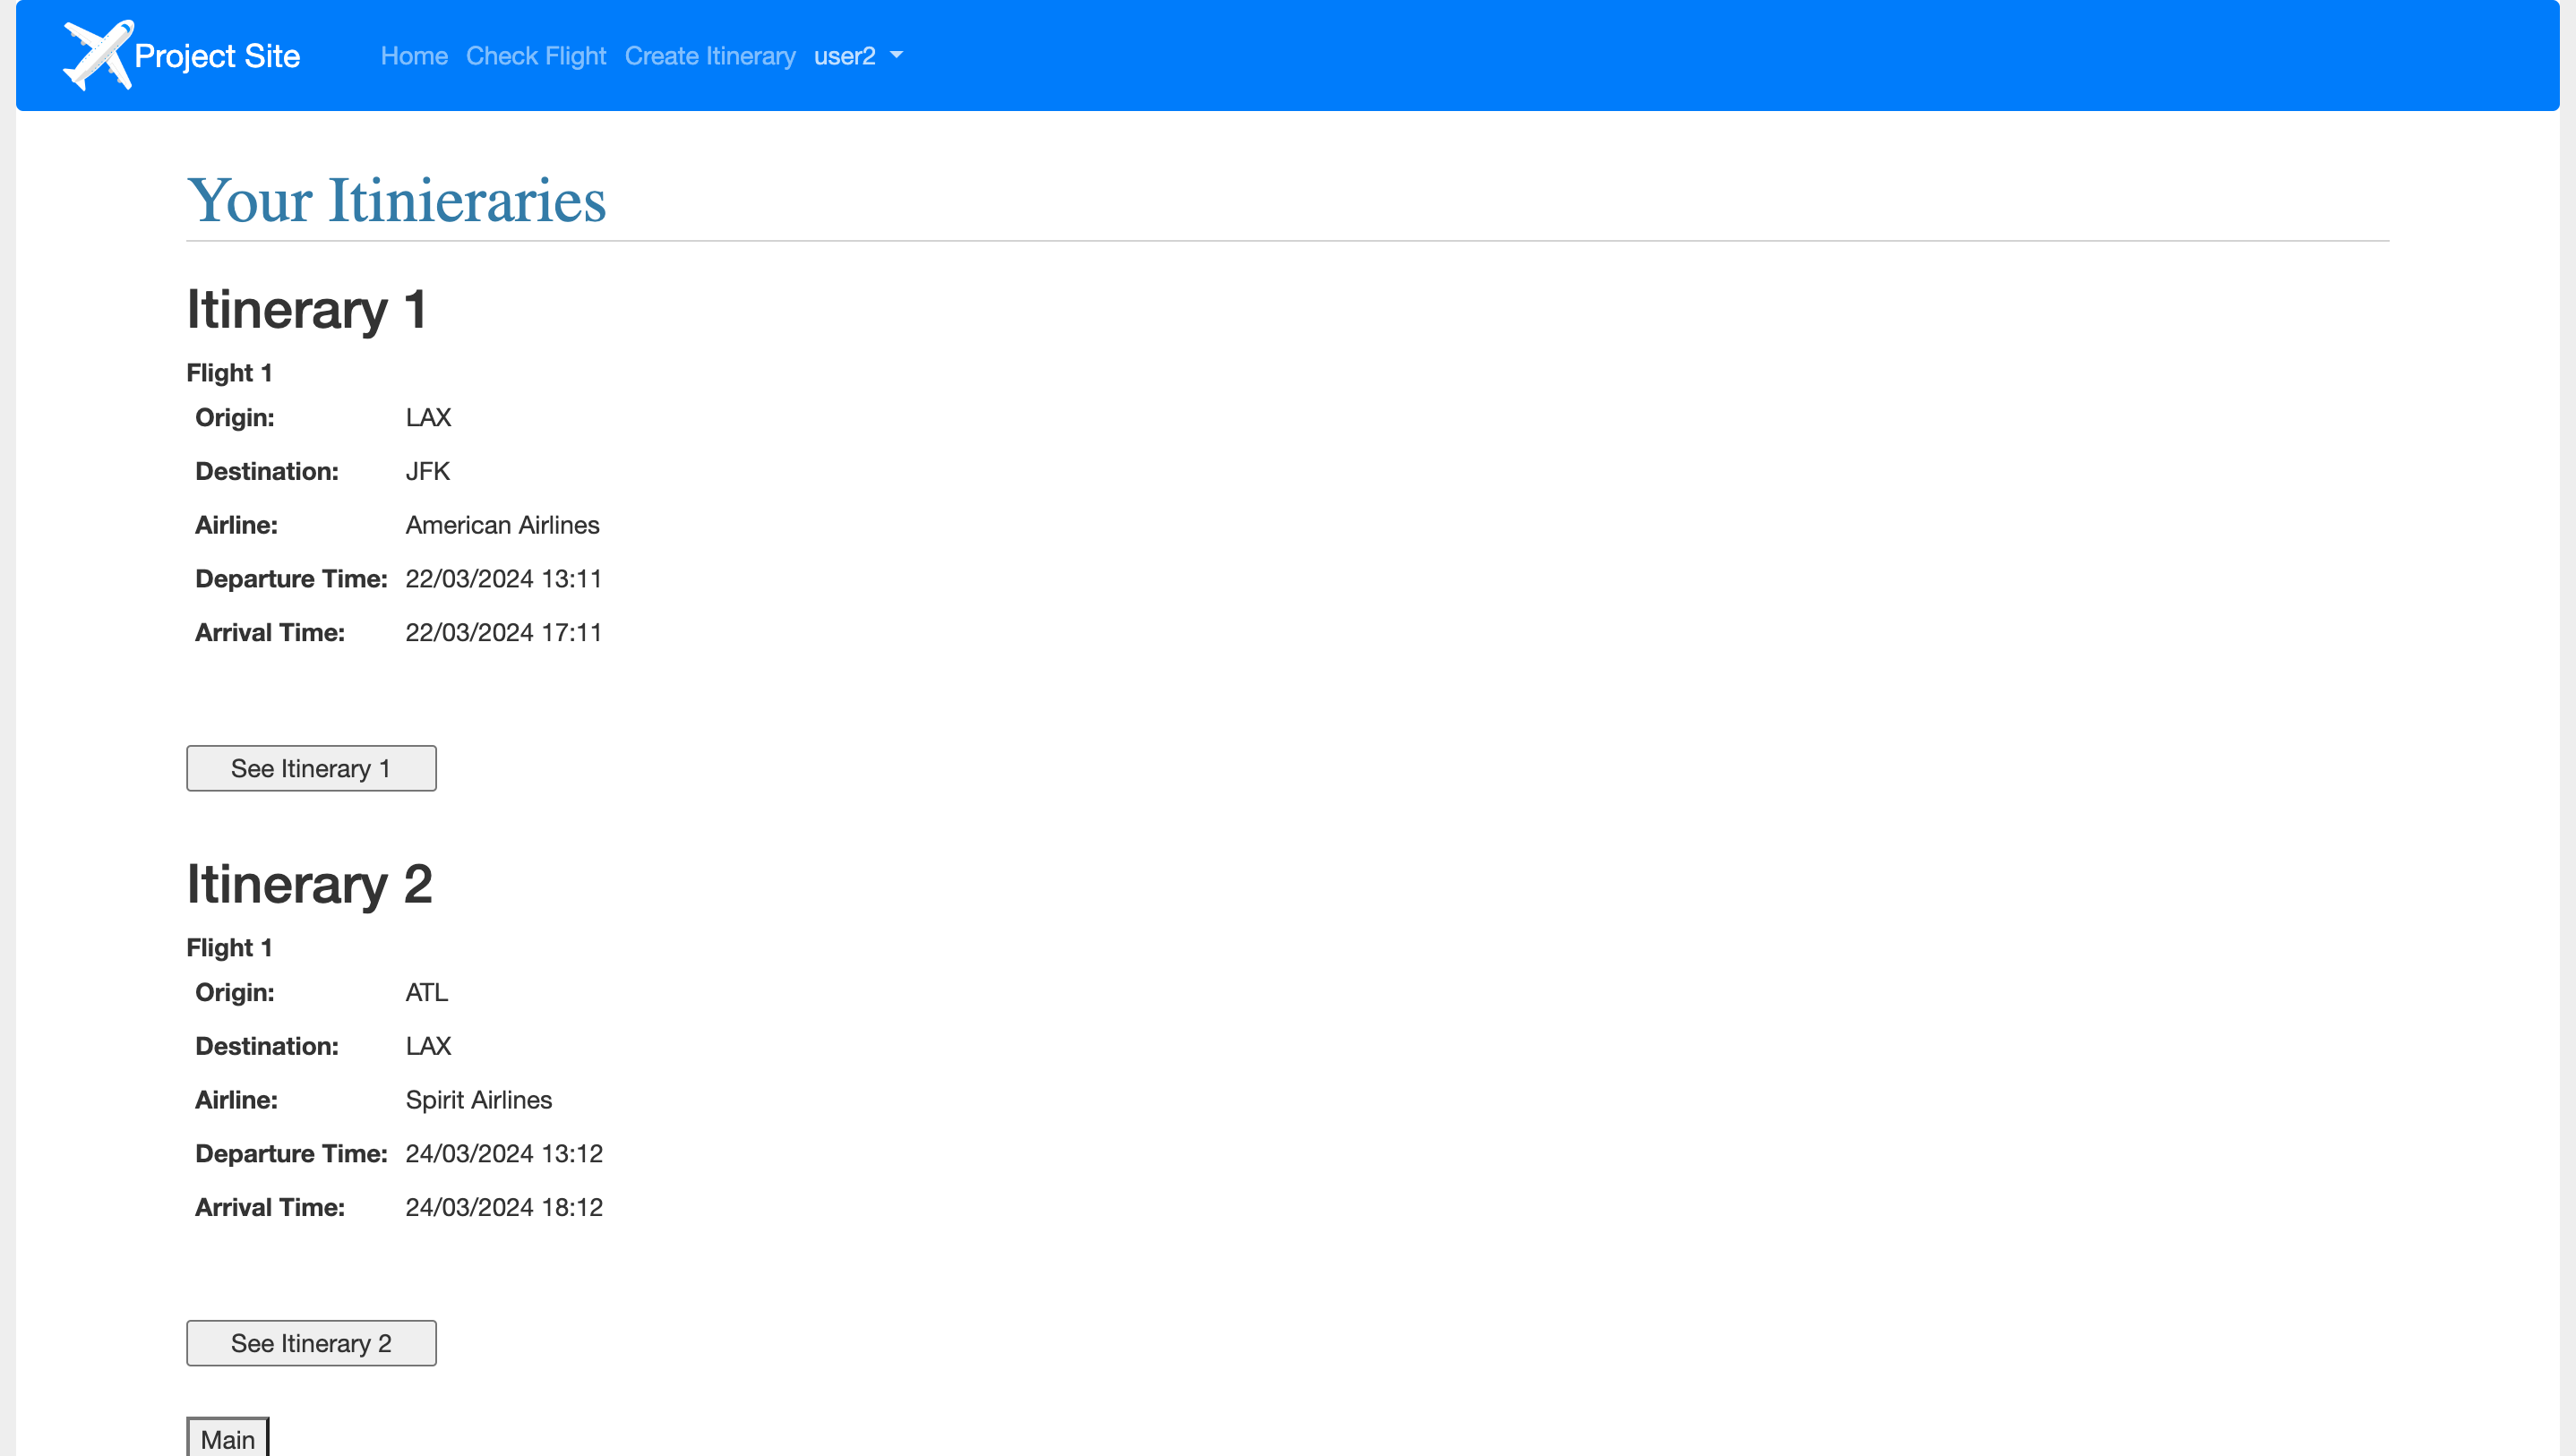

## 4. Adding Interactive Visualizations with Plotly Dash

This Plotly Dash app is an interactive tool designed to give users insights into flight delays and travel patterns across U.S. airports.

We pulled the data from the database we created as described in part 2, and used this data to create our visualizations.

For faster processing time, we decided to process the data first and writing them out to separate CSV files that were suited for each visualization instead of processing the data within our Dash app.

It features three core visualizations:

1. **Flight Routes Visualization**: Users can input up to ten pairs of departure and arrival airport codes to plot the routes on a map. The routes are color-coded by average delay proportions, helping users identify which routes typically experience more delays.

2. **Heatmap**: This displays a heatmap overlay on a U.S. map, showing the volume of flights departing from each airport (denoted by the size of the circles) and the proportion of those flights that are delayed (indicated by the color intensity).

3. **Rush Hour Analysis**: By entering an airport code and a specific hour, users can generate a bar chart that reveals the busiest times for departures at that airport, providing insights into peak travel hours and potential rush times.

The app's layout includes a markdown block at the top that explains the functionalities and how to use the app. A `RadioItems` selection lets users choose between the flight routes, heatmap, or rush hour visualizations, dynamically updating the display content based on their choice.

Callbacks are set up to respond to user interactions, such as entering airport codes and clicking the "Plot Routes" button, which generates the visualizations accordingly. For the heatmap and rush hour charts, the app processes flight count and delay data, providing a detailed analysis of travel patterns for better planning and decision-making. The app is equipped to handle data transformations and plotting, making it a comprehensive tool for travelers looking to optimize their itineraries.

### **Here is a more detailed look at each visualization**
### **Flight Routes Visualization:**

This app allows you to visualize flight routes between airports and the average proportion of delays. Enter the airport codes for departures and arrivals, and press "Plot Routes" to see the routes on the map.

Each number in the legend is a group number that represents the proportion of delayed flights on average for each route.

Here is what each number in the legend means:

        - 0: delay proportion <= 0.1
        - 1: 0.1 < delay proportion <= 0.15
        - 2: 0.15 < delay proportion <= 0.2
        - 3: 0.2 < delay proportion <= 0.25
        - 4: 0.25 < delay proportion <= 0.3
        - 5: delay proportion > 0.3


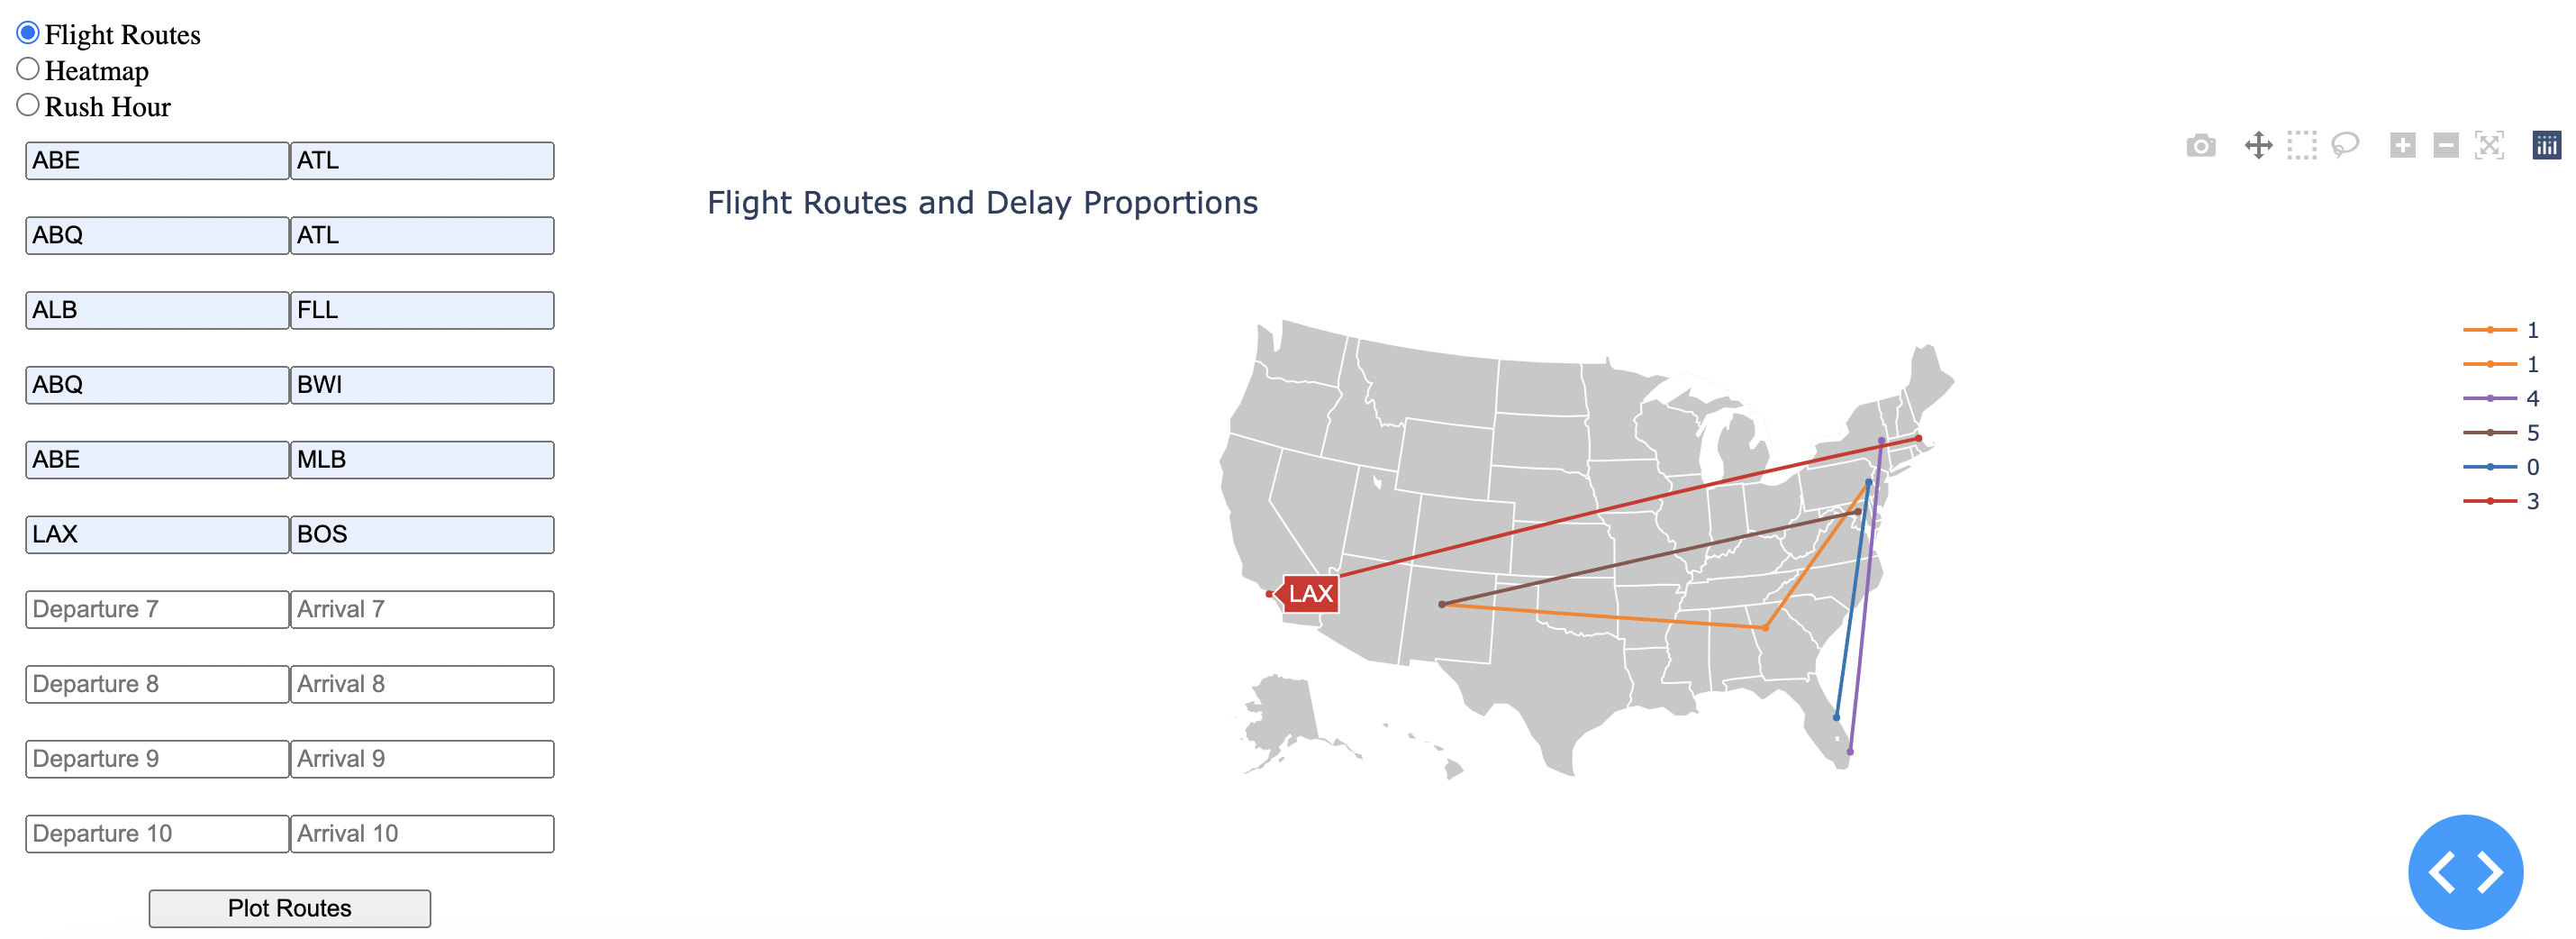

In [ ]:
# @title Flight Routes Visualization
from IPython.display import Image, display

# Correct path with no spaces in folder names
image_path = '/content/drive/MyDrive/PIC16B_Datasets/routes.png'

# Display the image
display(Image(filename=image_path))

**Callback: `update_map`**

This callback listens for user interaction with the 'Plot Routes' button or changes in the visualization mode selector. Upon activation, it processes user input to plot flight routes between selected departure and arrival airports. The callback assembles a list of route data based on the input fields for up to 10 routes.

In [ ]:
# Callback to update the map based on the inputs
@app.callback(
    #Output('content-route', 'children'),
    Output('map', 'figure'),
    [Input('vis-mode-selector', 'value'),
     Input('plot-button', 'n_clicks')
    ],
    [State({'type': 'departure-input', 'index': ALL}, 'value'),
     State({'type': 'arrival-input', 'index': ALL}, 'value'),
    ]
)

**Function: `update_map`**

This function is the core of the `update_map` callback. It transforms user input into uppercase to match the database format, constructs a key for each route combining departure and arrival airport codes, and retrieves relevant data like group classification, flight count, and delay proportion. It then checks for the existence of coordinates for the given airports and, if found, prepares a structured dictionary of route information to be plotted.

In [ ]:
def update_map(n_clicks, vis_mode, departures, arrivals):
    """
    Responds to user inputs to generate and update a flight route map.

    Parameters:
    - n_clicks (int): Number of times the plot button has been clicked.
    - vis_mode (str): The visualization mode selected by the user.
    - departures (list): List of user-input departure airport codes.
    - arrivals (list): List of user-input arrival airport codes.

    Returns:
    - Plotly Figure: A figure object that contains the updated flight routes map.
    """
    routes = []

    departures = [dep.upper() for dep in departures if dep is not None]
    arrivals = [arr.upper() for arr in arrivals if arr is not None]

    # loop through each pair of depature and arrival inputs
    for dep, arr in zip(departures, arrivals):
        if dep and arr:  # Ensure both inputs are provided
            # Generate the composite key for the current route
            route_key = f"{dep}_{arr}"
            # Look up the group for the current route
            group = route_dict.get(route_key)
            count = count_dict.get(route_key)
            delay_proportion = dep_del_dict.get(route_key)
            dep_coords = airport_coordinates.get(dep)
            arr_coords = airport_coordinates.get(arr)

            # Proceed only if coordinates for both airports are found
            if dep_coords and arr_coords:
                # Construct the route data structure
                route = {
                    "departure_airport": dep,
                    "arrival_airport": arr,
                    "departure_lat": dep_coords['lat'],
                    "departure_lon": dep_coords['lon'],
                    "arrival_lat": arr_coords['lat'],
                    "arrival_lon": arr_coords['lon'],
                    "delay_proportion": delay_proportion,
                    "group": group,
                    "flight_count": count
                }
                routes.append(route)

    fig = create_figure_with_routes(routes)

    return fig

**Function: `create_figure_with_routes`**

This function takes the list of routes created by `update_map` and visualizes them on a map. Each route is represented as a line between its departure and arrival coordinates with markers at each airport. The lines and markers are color-coded by delay proportion group. The function sets up the map's appearance, including its geographic projection (set to the United States) and styling details. The resulting figure is then returned to the update_map callback to update the 'map' component in the app's layout.

In [ ]:
def create_figure_with_routes(routes):
    """
    Creates a Plotly map visualization for the given flight routes.

    Parameters:
    - routes (list): A list of dictionaries, each containing data for a flight route.

    Returns:
    - Plotly Figure: A figure object that visualizes the flight routes on a map.
    """
    fig = go.Figure()
    # Define a color scheme for the different groups
    group_colors = {
        0: "#1f77b4",  # Muted blue
        1: "#ff7f0e",  # Safety orange
        2: "#2ca02c",  # Cooked asparagus green
        3: "#d62728",  # Brick red
        4: "#9467bd",  # Muted purple
        5: "#8c564b",  # Chestnut brown
    }
    # Loop through each route and add it to the figure with the respective color
    for route in routes:
        # Get the color for the current group or default to black if not found
        route_color = group_colors.get(route["group"])

        fig.add_trace(
            go.Scattergeo(
                lon = [route["departure_lon"], route["arrival_lon"]],
                lat = [route["departure_lat"], route["arrival_lat"]],
                text = [f"{route['departure_airport']}", f"{route['arrival_airport']}"],
                hoverinfo='text',
                mode = "lines+markers",
                line = dict(width = 2, color = route_color),
                marker = dict(size = 4, color = route_color),
                name = route["group"],
            )
        )
        # Update layout of the map
    fig.update_layout(
        title_text = "Flight Routes and Delay Proportions",
        showlegend = True,
        geo = dict(
            projection_type = "albers usa",
            showland = True,
            landcolor = "rgb(200, 200, 200)",
            countrycolor = "rgb(204, 204, 204)",
            showsubunits=True,  # Show state lines and other subunits
            subunitwidth=1  # Width of the subunit lines (state lines)
        ),
    )
    return fig

### **Heatmap Visualization:**
The heatmap illustrates U.S. airport departures, highlighting flight volume and delay frequency.

Larger circles denote more flights; color intensity reflects higher delay percentages.



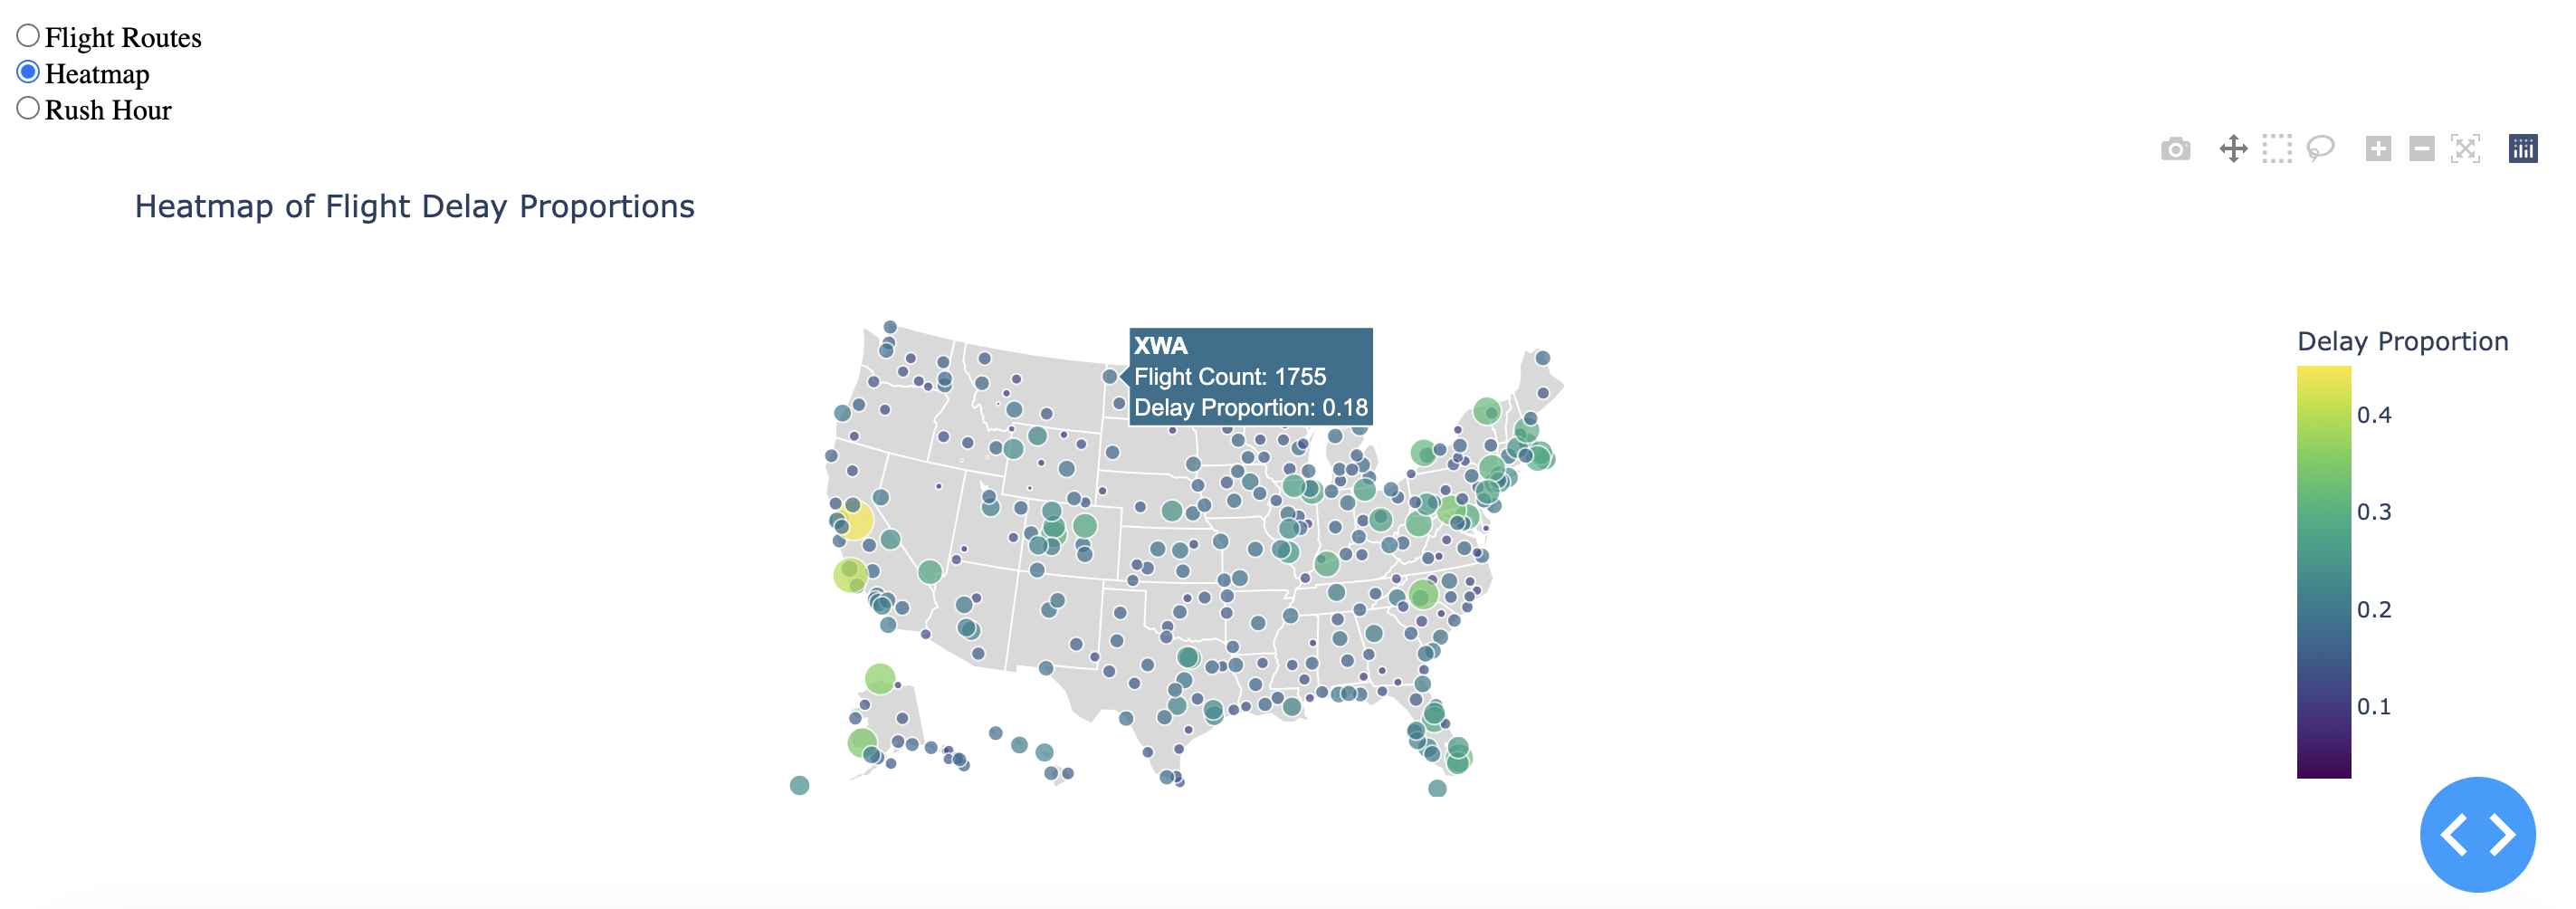

In [ ]:
# @title Heatmap

# Correct path with no spaces in folder names
image_path1 = '/content/drive/MyDrive/PIC16B_Datasets/heatmap.png'

# Display the image
display(Image(filename=image_path1))

**Callback: create_composite_map**

This callback updates the content of the 'content-heatmap' division based on the visualization mode selected by the user. When the 'Heatmap' mode is selected, it triggers the create_composite_map function to generate and display a heatmap.

In [ ]:
@app.callback(
    Output('content-heatmap', 'children'),
    Input('vis-mode-selector', 'value')
)

**Function: create_composite_map**

The create_composite_map function constructs a heatmap visualization of U.S. flight departures. It uses the `Scattergeo` trace of Plotly to plot the longitude and latitude of origin airports as points on a map.

Each point's size represents the delay proportion, offering a visual representation of the flight volume and delay frequency. The color intensity corresponds to higher delay percentages.

The hovertemplate enriches the points with interactive data display on hover, showing the flight count and delay proportion for each airport. The function returns a Plotly figure object configured with a title and a stylized geographical layout, ready to be rendered in the app.

In [ ]:
def create_composite_map():
    """
    Generates a heatmap Plotly figure displaying U.S. airport flight delays.

    Size of points reflects flight count; color indicates delay proportions.

    Returns:
    - Plotly Figure: A map with scaled markers for visualizing flight delays.
    """

    fig = go.Figure(data=go.Scattergeo(
        lon = dep_delay['ORIGIN_LONGITUDE'],
        lat = dep_delay['ORIGIN_LATITUDE'],
        text = dep_delay['ORIGIN'],
        customdata = dep_delay[['flight_count', 'DEP_DEL15']],  # Add flight count and delay proportions to the custom data
        hovertemplate = (
            "<b>%{text}</b><br>"
            "Flight Count: %{customdata[0]}<br>"
            "Delay Proportion: %{customdata[1]:.2f}<extra></extra>"  # Format delay proportion to show two decimal places
        ),
        marker = dict(
            size = dep_delay['DEP_DEL15'] * 50,  # Scale the points based on delay proportion
            color = dep_delay['DEP_DEL15'],
            colorscale = 'Viridis',
            showscale = True,
            colorbar_title = 'Delay Proportion'
        )
    ))

    fig.update_layout(
        title = 'Heatmap of Flight Delay Proportions',
        geo = dict(
            scope = 'usa',
            projection_type = 'albers usa',
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitcolor = "rgb(255, 255, 255)"
        )
    )



    return fig

### **Rush Hour:**

This app offers insights into the frequency and peak hours of flight departures from specific airports.

By inputting an airport code and a flight's departure time, users can generate a bar chart that reveals the airport's busiest periods, aiding in understanding rush hour trends.

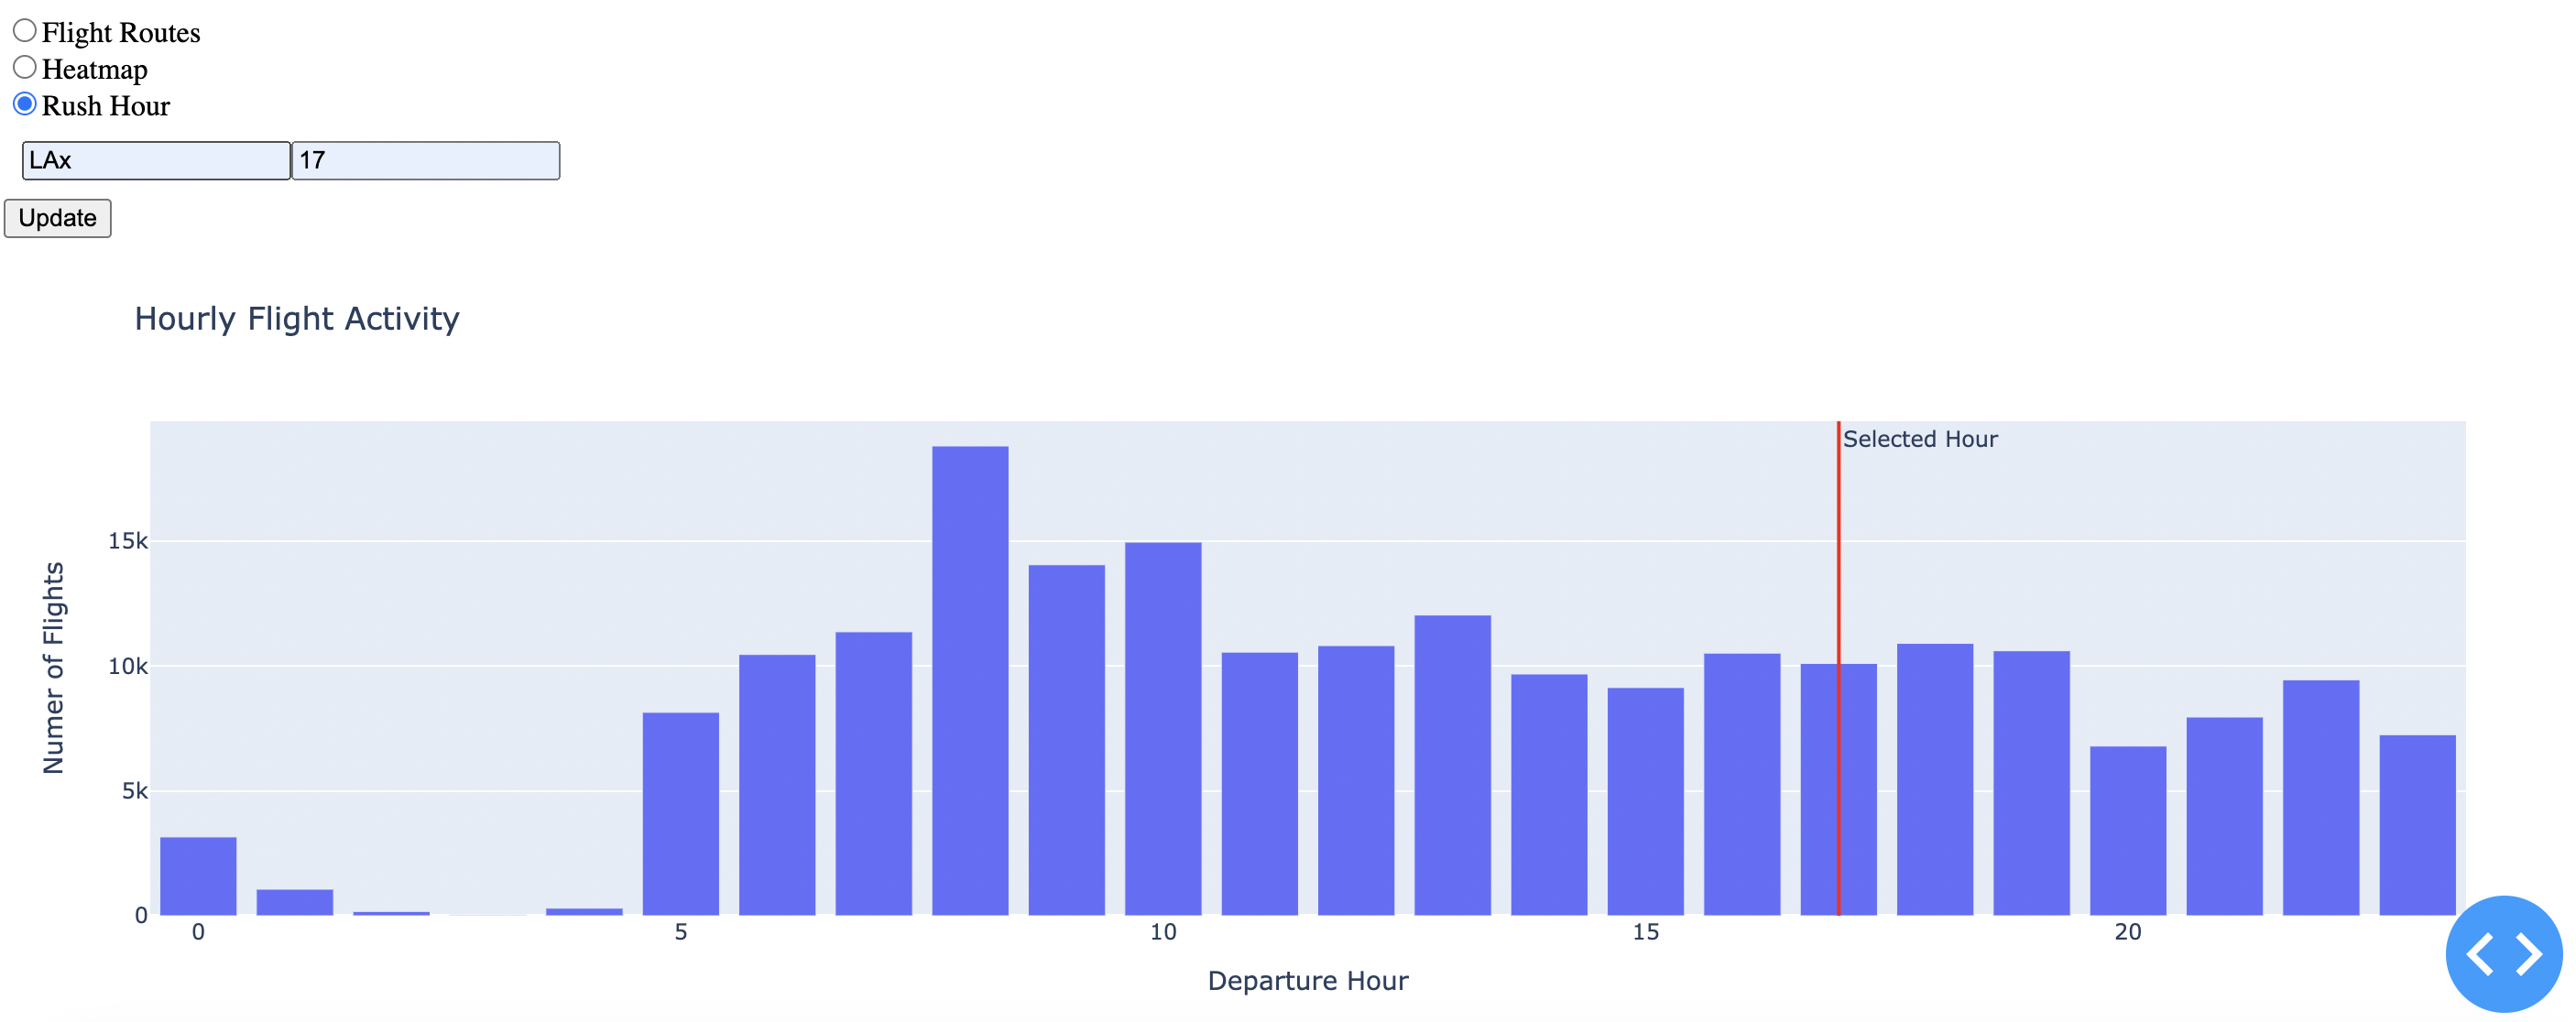

In [ ]:
# @title Rush Hour
from IPython.display import Image, display

# Correct path with no spaces in folder names
image_path2 = '/content/drive/MyDrive/PIC16B_Datasets/rush_hour.png'

# Display the image
display(Image(filename=image_path2))

**Callback: update_hourly_activity**

This callback updates the histogram visualization for hourly flight activity based on user interaction. It triggers when the user selects a visualization mode and clicks the 'Update' button. The callback receives the airport code and hour input by the user and passes this information to the `update_hourly_activity` function to refresh the histogram display.

In [ ]:
@app.callback(
    Output('hist', 'figure'),
    [Input('vis-mode-selector', 'value'),
     Input('update-button', 'n_clicks')],
    [State('origin-input', 'value'), State('hour-input', 'value')]
)

**Function: `update_hourly_activity`**

This function creates a histogram to display the number of flights for each hour from a specified airport. It takes user inputs for the airport and hour, converts the airport code to uppercase, filters the dataset for the selected airport, and constructs a bar chart. If an hour is provided, it highlights that hour on the chart. The function returns a Plotly figure object with the updated histogram for rendering in the app.

In [ ]:
def update_hourly_activity(n_clicks, vis_mode, selected_origin, selected_hour):
    """
    Generates a histogram figure of flight counts for each hour of the day based on user-selected origin and hour.

    This function filters the data for the specified airport origin and hour, then produces a bar plot showing the
    number of flights departing at each hour of the day. If an hour is selected, it highlights that hour on the histogram.

    Parameters:
    - n_clicks (int): Number of clicks received. This parameter can be used to trigger the function in a callback.
    - vis_mode (str): The visualization mode. Currently unused in the function but can be utilized for future modes.
    - selected_origin (str): The airport origin code selected by the user.
    - selected_hour (int/str): The hour selected by the user for highlighting in the histogram.

    Returns:
    - fig (plotly.graph_objs._figure.Figure): A Plotly figure object containing the histogram of hourly flight activity.
    """

    if selected_origin is not None:
        selected_origin = selected_origin.upper()

    # Otherwise, generate the histogram for the selected origin and hour
    filtered_df = dep_count[dep_count['ORIGIN'] == selected_origin]

    # Create a barplot of flights by hour
    # First, we create the text that will be displayed on each bar
    filtered_df['text'] = 'Airport: ' + filtered_df['ORIGIN'] \
                      + '<br>Hour: ' + filtered_df['dep_hour'].astype(str) \
                      + '<br>Flights: ' + filtered_df['dep_count'].astype(str)

    # Now we can create the bar plot
    fig = px.bar(filtered_df, x='dep_hour', y='dep_count', title='Hourly Flight Activity')

    fig.update_layout(xaxis_title='Departure Hour', yaxis_title='Numer of Flights')
    # To add hover text, you can use the hover_data parameter
    fig.update_traces(hovertemplate=filtered_df['text'])

    # Highlight the selected hour if one is selected

    try:
        selected_hour = int(selected_hour)
        if 0 <= selected_hour <= 23:
            fig.add_vline(x=selected_hour, line_color="red", annotation_text="Selected Hour")
    except (ValueError, TypeError):
        pass

    return fig

## 6. Conclusions

In conclusion, we created a Flask web app that helps users predict whether or not their flight will be delayed. Our project aims to predict flight delays, offering substantial benefits to travelers and airports by providing more accurate departure times and enhancing planning efficiency. However, it faces challenges such as data quality and availability, computational limitations, and the complexity of developing predictive models. Mitigating these risks requires thorough data assessment, scalable processing solutions, and flexible project scope management. Ethically, while the project presents an opportunity to improve the travel experience for passengers and operational efficiency for airports, it may also highlight airlines' operational shortcomings, potentially impacting their reputation. Despite these considerations, the project stands to make a positive impact by enabling better-informed travel decisions and streamlining airport traffic management, contributing to a more predictable and less stressful travel experience for all involved. As far as any ethical concerns, there are very few that we have been able to identify. The only such concern may be that the airlines would not be happy with their constant delays being exposed.